<a href="https://colab.research.google.com/github/subjikoji/projects/blob/time-series/Eco2460_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ml model (with macroeconomics factors) vs time series model with rejection sampling?
1. We pick a new model(Neural Network LSTM)
2. We only pick main features from the paper(and the result is not good, so market is efficient?)
3. We introduce a new technique(Rejection sampling) on time series model
4. We compare the results of them

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.stats import lognorm, chi2, t
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels.api as sm



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasClassifier

# Machine Learning

Data Preparation

In [ ]:
gold = pd.read_excel('gold price.xlsx')
vix = pd.read_csv('vxocurrent.csv')
vix['Date    '] = vix['Date    '].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y-%m-%d'))
vix = vix.rename(columns={'Date    ': 'Date'})
vix['Date'] = pd.to_datetime(vix['Date'])
gold = gold.rename(columns={'Time': 'Date'})
df = pd.merge(vix, gold, on = 'Date')[['Date', 'Close', 'Price']]

We will use vix 1, 2, 3, 4 and gold price 3

In [ ]:
df['trend'] = df['Close'].diff().apply(lambda x: 1 if x > 0 else 0)
df['goldtrend'] = df['Price'].diff().apply(lambda x: 1 if x > 0 else 0)

df['vix1'] = df['trend'].shift(1)
df['vix2'] = df['trend'].shift(2)
df['vix3'] = df['trend'].shift(3)
df['vix4'] = df['trend'].shift(4)
df['gold3'] = df['goldtrend'].shift(3)

new_df = df.dropna()

In [ ]:
indep = ['vix1', 'vix2', 'vix3', 'vix4', 'gold3']
X = new_df[indep]
y = new_df['trend']

Model Training and Selection(ML)

In [ ]:
validation_size = 100
test_size = 100

tscv = TimeSeriesSplit(n_splits=2)

XGBoost

Parameters: `n_estimators`, `learning _rate`, `max_depth`

In [ ]:
ne = [i for i in range(15, 30)]
lr = [i for i in np.arange(0.01, 0.2, 0.001)]
md = [i for i in range(1, 4)]
params = list(itertools.product(ne, lr, md))
xgb_accuracy = []
for param in tqdm(params):
  model = XGBClassifier(n_estimators = param[0],
                        max_depth = param[2],
                        learning_rate = param[1])

  mean_accuracies = []

  # Perform the 2-fold cross validation
  for train_index, test_index in tscv.split(X):
      # Split the data into training and test sets
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # Split the training set into training and validation sets
      X_train, X_val = X_train[:-validation_size], X_train[-validation_size:]
      y_train, y_val = y_train[:-validation_size], y_train[-validation_size:]

      # Train the model on the training set
      model.fit(X_train, y_train)

      # Make predictions on the validation set
      y_pred = model.predict(X_val)

      # Compute the mean accuracy on the validation set
      mean_accuracy = accuracy_score(y_val, y_pred)
      mean_accuracies.append(mean_accuracy)

  mean_accuracy = np.mean(mean_accuracies)
  xgb_accuracy.append(mean_accuracy)



100%|██████████| 8550/8550 [07:45<00:00, 18.35it/s]


In [ ]:
idx = np.argmax(xgb_accuracy)
train_X, test_X = X[:-100], X[-100:]
train_y, test_y = y[:-100], y[-100:]
model = XGBClassifier(n_estimators = params[idx][0],
                      learning_rate = params[idx][1],
                        max_depth = params[idx][2]
                        )
model.fit(train_X, train_y)

pred_y = model.predict(test_X)

# Compute the accuracy on the test set
test_accuracy = accuracy_score(test_y, pred_y)
precision_0 = precision_score(test_y, pred_y, pos_label=0)
recall_0 = recall_score(test_y, pred_y, pos_label=0)
precision_1 = precision_score(test_y, pred_y, pos_label=1)
recall_1 = recall_score(test_y, pred_y, pos_label=1)
print('Accuracy (test set):', test_accuracy)
print('Precision of class 0:', precision_0)
print('Recall of class 0:', recall_0)
print('Precision of class 1:', precision_1)
print('Recall of class 1:', recall_1)

Accuracy (test set): 0.53
Precision of class 0: 0.5232558139534884
Recall of class 0: 0.8823529411764706
Precision of class 1: 0.5714285714285714
Recall of class 1: 0.16326530612244897


In [ ]:
params[idx]

(15, 0.1229999999999999, 1)

Light GBM

Parameters: `n_estimators`, `learning _rate`, `max_depth`, `reg_lambda`

In [ ]:
ne = [i for i in range(1005, 1026)]
lr = [i for i in np.arange(35, 46, 1)]
md = [i for i in range(1, 4)]
reg = [i for i in np.arange(80000, 120000, 10000)]
params = list(itertools.product(ne, lr, md, reg))
lgb_accuracy = []
for param in tqdm(params):
  model = LGBMClassifier(n_estimators = param[0],
                        max_depth = param[2],
                        learning_rate = param[1],
                        reg_lambda = param[3])

  mean_accuracies = []

  # Perform the 2-fold cross validation
  for train_index, test_index in tscv.split(X):
      # Split the data into training and test sets
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # Split the training set into training and validation sets
      X_train, X_val = X_train[:-validation_size], X_train[-validation_size:]
      y_train, y_val = y_train[:-validation_size], y_train[-validation_size:]

      # Train the model on the training set
      model.fit(X_train, y_train)

      # Make predictions on the validation set
      y_pred = model.predict(X_val)

      # Compute the mean accuracy on the validation set
      mean_accuracy = accuracy_score(y_val, y_pred)
      mean_accuracies.append(mean_accuracy)


  mean_accuracy = np.mean(mean_accuracies)
  lgb_accuracy.append(mean_accuracy)

100%|██████████| 2772/2772 [18:09<00:00,  2.54it/s]


proj_u(x) = (dot(x,u) / dot(u,u)) *

In [ ]:
idx = np.argmax(lgb_accuracy)
train_X, test_X = X[:-100], X[-100:]
train_y, test_y = y[:-100], y[-100:]
model = LGBMClassifier(n_estimators = params[idx][0],
                      learning_rate = params[idx][1],
                        max_depth = params[idx][2],
                       objective = 'binary',
                       reg_lambda = 100000
                        )
model.fit(train_X, train_y)

pred_y = model.predict(test_X)

# Compute the accuracy on the test set
test_accuracy = accuracy_score(test_y, pred_y)
precision_0 = precision_score(test_y, pred_y, pos_label=0)
recall_0 = recall_score(test_y, pred_y, pos_label=0)
precision_1 = precision_score(test_y, pred_y, pos_label=1)
recall_1 = recall_score(test_y, pred_y, pos_label=1)
print('Accuracy (test set):', test_accuracy)
print('Precision of class 0:', precision_0)
print('Recall of class 0:', recall_0)
print('Precision of class 1:', precision_1)
print('Recall of class 1:', recall_1)

Accuracy (test set): 0.53
Precision of class 0: 0.524390243902439
Recall of class 0: 0.8431372549019608
Precision of class 1: 0.5555555555555556
Recall of class 1: 0.20408163265306123


In [ ]:
params[idx]

(1005, 35, 3, 110000)

LSTM(Even worse.....)

In [ ]:
def create_model(neurons=128, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

train_X, test_X = X[:-100], X[-100:]
train_y, test_y = y[:-100], y[-100:]
train_X=train_X.values
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# Create LSTM model
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define hyperparameters to tune
param_grid = {
    'neurons': [64, 128, 256],
    'dropout_rate': [0.2, 0.3, 0.4],
    'optimizer': ['adam', 'rmsprop']
}



# Perform grid search with 5-fold cross validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_search.fit(train_X, train_y)

# Print best parameters and accuracy score
print("Best parameters: ", grid_search.best_params_)


<ipython-input-70-6d49bad24e0a>:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Best parameters:  {'dropout_rate': 0.2, 'neurons': 64, 'optimizer': 'adam'}


In [ ]:
train_X, test_X = X[:-100], X[-100:]
train_y, test_y = y[:-100], y[-100:]
train_X=train_X.values
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

test_X=test_X.values
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
model = create_model(neurons=grid_search.best_params_['neurons'],
                     dropout_rate=grid_search.best_params_['dropout_rate'],
                     optimizer=grid_search.best_params_['optimizer'])
model.fit(train_X, train_y, epochs=50, batch_size=64)

In [ ]:
pred_y = model.predict(test_X)
pred_y = (pred_y > 0.45).astype(int)

test_accuracy = accuracy_score(test_y, pred_y)
precision_0 = precision_score(test_y, pred_y, pos_label=0)
recall_0 = recall_score(test_y, pred_y, pos_label=0)
precision_1 = precision_score(test_y, pred_y, pos_label=1)
recall_1 = recall_score(test_y, pred_y, pos_label=1)
print('Accuracy (test set):', test_accuracy)
print('Precision of class 0:', precision_0)
print('Recall of class 0:', recall_0)
print('Precision of class 1:', precision_1)
print('Recall of class 1:', recall_1)

4/4 [==============================] - 0s 6ms/step
Accuracy (test set): 0.52
Precision of class 0: 0.5405405405405406
Recall of class 0: 0.39215686274509803
Precision of class 1: 0.5079365079365079
Recall of class 1: 0.6530612244897959


# Time Series

In [ ]:
vix = pd.read_csv("vxocurrent.csv")
vix = vix.rename(columns={'Date    ': 'Date'})

We define $y_t = logVIX_t$

In [ ]:
logvix = np.log2(vix['Close'])

We can see that the autocorrelation falls under the confidence interval starting  h≈200 . The slowly declaying autocorrelation indicates non-stationarity of the series.

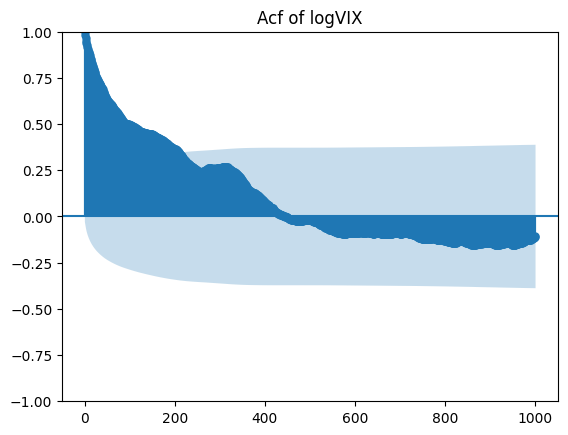

In [ ]:
plot_acf(logvix, lags = 1000)
plt.title("Acf of logVIX")
plt.show()

We can see from the ACF plot that by differencing the series, we have created a new series that is stationary. The autocorrelation drops sharply after  h=0  (which is correlation with itself) and almost immediately falls wihtin the confidence interval at around h=2. We observe similar patterns on pacf, which suggests that AR(2) might be a good choice. Using the ar_select_order function, we can check that AR(2) is the ideal model of choice, based on information criteria.

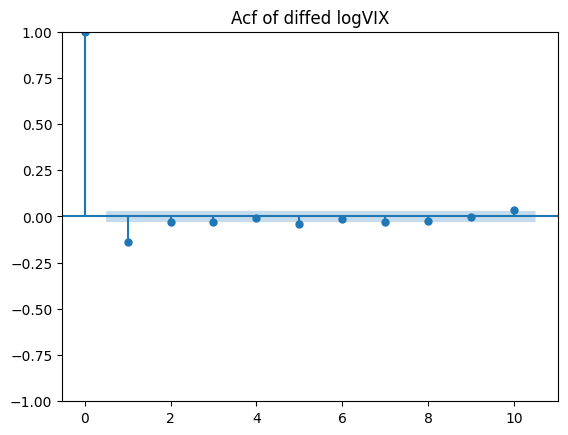

In [ ]:
dlogvix = logvix.diff().dropna()
plot_acf(dlogvix, lags = 10)
plt.title("Acf of diffed logVIX")
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


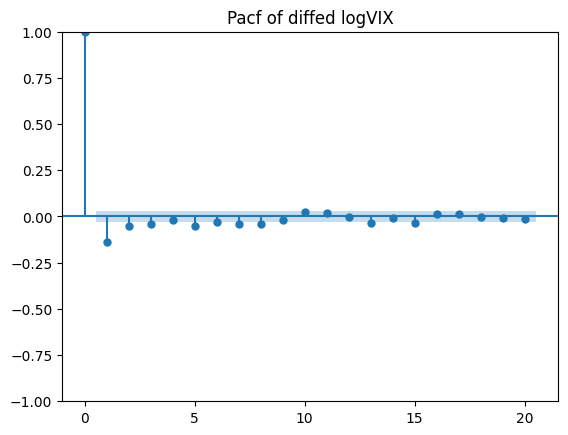

In [ ]:
plot_pacf(dlogvix, lags = 20)
plt.title("Pacf of diffed logVIX")
plt.show()

In [ ]:
sel = ar_select_order(dlogvix, 20, seasonal= False, old_names= False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 4283
Model:                     AutoReg(2)   Log Likelihood                3034.971
Method:               Conditional MLE   S.D. of innovations              0.119
Date:                Sun, 09 Apr 2023   AIC                          -6061.942
Time:                        20:23:24   BIC                          -6036.494
Sample:                             2   HQIC                         -6052.953
                                 4283                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.002      0.069      0.945      -0.003       0.004
Close.L1      -0.1452      0.015     -9.511      0.000      -0.175      -0.115
Close.L2      -0.0526      0.015     -3.445      0.0

Now we specify a regression model of the form $Δy_t = \phi_1Δy_{t-1} + \phi_2Δy_{t-1}^2 +\epsilon_t$. We run a linear regression estimate below. While the coefficients are significant for both lagged terms, the overall prediction performance is very poor ($R^2 \approx 0.02$).

The efficient market hypothesis says that the current price contains all the useful information, and best prediction of future price is current price. Specifically, the efficient market hypothesis says that the price of assets should follow a random walk, and thus price change cannot be predicted by past price changes. This is supported by the low $R^2$ of the regression, despite the significant coefficient estimates, which indicates most of the information in predicting change in asset price still comes from the noise.


In [ ]:
X = np.stack((np.array(dlogvix[:-1]), np.array(dlogvix[:-1]**2)), axis=1)
x = sm.add_constant(X)

#fit linear regression model
model = sm.OLS(dlogvix[1:], x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     47.69
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           3.26e-21
Time:                        20:29:22   Log-Likelihood:                 3035.8
No. Observations:                4282   AIC:                            -6066.
Df Residuals:                    4279   BIC:                            -6047.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.357      0.1

Below we plot the ACF of the noise, square of the noise, and the historical distribution of the noise respectively. We can see that autocorrelation is zero for most $h \geq 1$, while the autocorrelation of squared residuals persists at low levels until $h=6$. From the histogram, we observe a leptokurtic distrubtion of residuals centred around 0. The residuals clearly are not normally distributed, and we can confirm this from its sample kurtosis of 5.1, which is much bigger than 3.

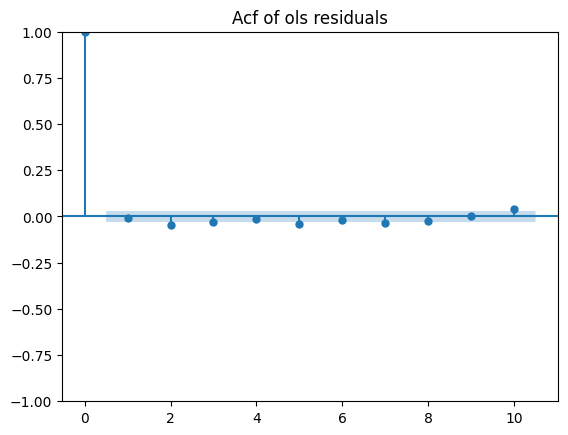

In [ ]:
plot_acf(model.resid, lags = 10)
plt.title("Acf of ols residuals")
plt.show()

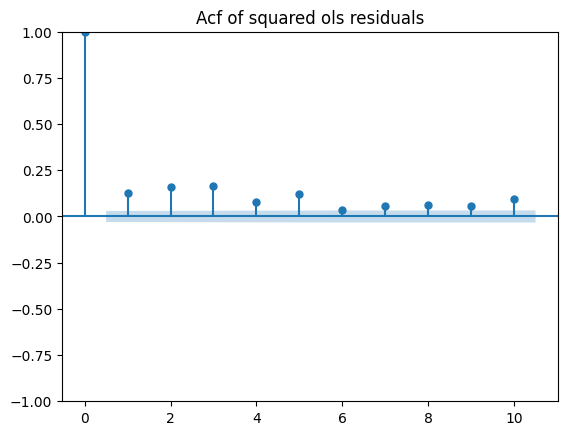

In [ ]:
plot_acf(model.resid**2, lags = 10)
plt.title("Acf of squared ols residuals")
plt.show()

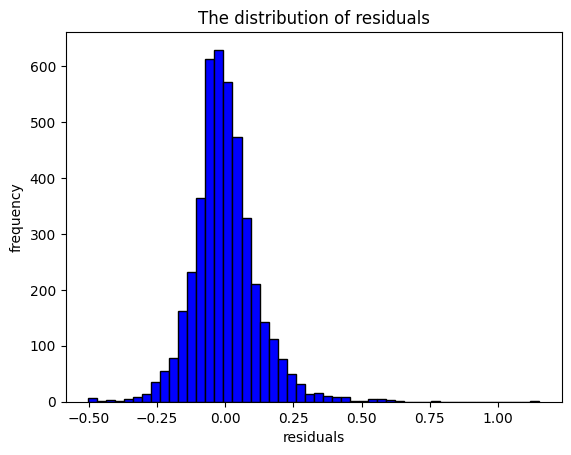

In [ ]:
plt.hist(model.resid, color = 'blue', edgecolor = 'black',
         bins = 50)
plt.xlabel('residuals')
plt.ylabel('frequency')
plt.title("The distribution of residuals")
plt.show()

In [ ]:
print("The mean is:", model.resid.mean())
print("The variance is:", model.resid.var())
print("The skewness is:", model.resid.skew())
print("The kurtosis is:", model.resid.kurtosis())

The mean is: 2.800188852394136e-18
The variance is: 0.014184785427271212
The skewness is: 0.9020745381538292
The kurtosis is: 5.18602704146413


From qq-plot we can get similar results, here is a qq-plot of normal distribution.

<Figure size 640x480 with 0 Axes>

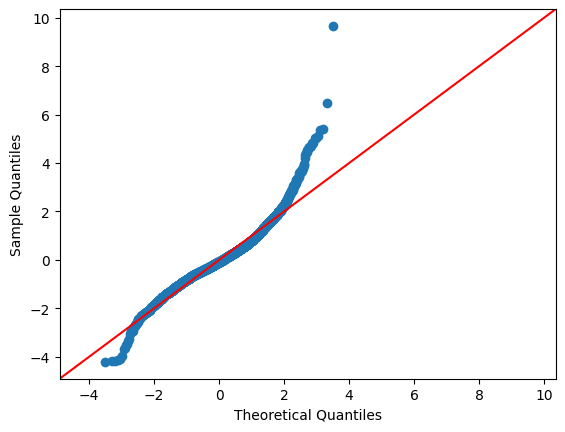

In [ ]:
plt.figure()
df_vix = (model.resid - model.resid.mean())/model.resid.std()
fig = sm.qqplot(df_vix, line = '45')
plt.show()

Now we will consider such model: $Δy_t = \phi_1Δy_{t-1} + \phi_2Δy_{t-1}^2 +\epsilon_t$. Since we know the distribution is follwing some distribution subordinate to Guassian, we will apply rejection sampling skill to approach the distribution of the error term, then introduce the simulated noise into our model. So our model will be: $Δy_t = \phi_1Δy_{t-1} + \phi_2Δy_{t-1}^2 +\phi_3\xi_t + \epsilon_t$, where \xi_t is the simulated noise.

To implement the sampling skill, we pick Laplace distribution($\frac{1}{2b}exp(-\frac{x-\mu}{b})$), since it has exponential tails that decay more slowly than the normal distribution

We first plot the distribution of Guassian and Laplace(0, 0.9), this is similar to the distribution that is proposed by Clark.

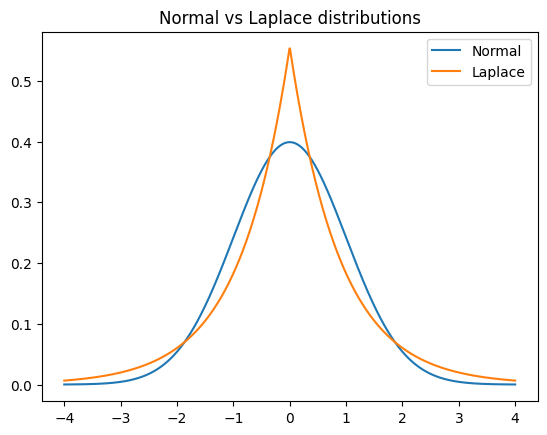

In [ ]:
# Define the range of the x-axis
x = np.linspace(-4, 4, num=1000)
b= 0.9
# Calculate the PDFs of the normal and Laplace distributions
pdf_norm = 1/(np.sqrt(2*np.pi)) * np.exp(-x**2/2)
pdf_laplace = 1/(2*b) * np.exp(-np.abs(x - 0)/b)

# Plot the PDFs of the two distributions
plt.plot(x, pdf_norm, label='Normal')
plt.plot(x, pdf_laplace, label='Laplace')

# Add a legend and title to the plot
plt.legend()
plt.title('Normal vs Laplace distributions')

# Show the plot
plt.show()

Rejection Sampling:
1. We generate a sample from the proposed Guassian distribution q(x).
2. The second, u is generated uniformly from the interval [0,cq(x)]
3. If u > the density of Laplace disbribution, then x is rejected. Otherwise we accept it.

By doing this, we are not sampling directly from Laplace distribution, but keep the properties of heavy tails compared to normal distribution. For simplicity, here we pick c=5, which is shown in the plot below.

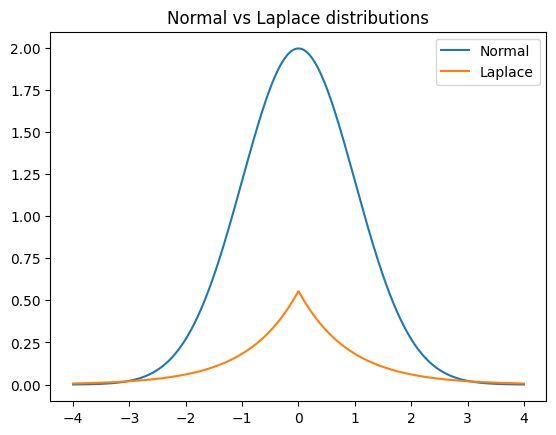

In [ ]:
# Define the range of the x-axis
x = np.linspace(-4, 4, num=1000)
b= 0.9
# Calculate the PDFs of the normal and Laplace distributions
pdf_norm = 5/(np.sqrt(2*np.pi)) * np.exp(-x**2/2)
pdf_laplace = 1/(2*b) * np.exp(-np.abs(x - 0)/b)

# Plot the PDFs of the two distributions
plt.plot(x, pdf_norm, label='Normal')
plt.plot(x, pdf_laplace, label='Laplace')

# Add a legend and title to the plot
plt.legend()
plt.title('Normal vs Laplace distributions')

# Show the plot
plt.show()

We still use 100 days as the testing set, and train the model with the other days.

So we:
1. Simulate noise for trainning and testing set, then check the model accuracy by converting the result into 1 and 0.
2. Repeat this step 100 times, calculate the average performance

In [ ]:
len_train = len(dlogvix[:-101])
test_accuracy = []
precision_0 = []
recall_0 = []
precision_1 = []
recall_1 = []
for i in tqdm(range(100)):
  train_noise = []
  while len(train_noise) < len_train:
    x= np.random.normal(0, 1)
    pdf_norm = 5/(np.sqrt(2*np.pi)) * np.exp(-x**2/2)
    pdf_laplace = 1/(2*0.9) * np.exp(-np.abs(x - 0)/0.9)
    mu = np.random.uniform(0, pdf_norm)
    if mu <= pdf_laplace:
      train_noise.append(x)

  test_noise = []
  while len(test_noise) < 100:
    x= np.random.normal(0, 1)
    pdf_norm = 5/(np.sqrt(2*np.pi)) * np.exp(-x**2/2)
    pdf_laplace = 1/(2*0.9) * np.exp(-np.abs(x - 0)/0.9)
    mu = np.random.uniform(0, pdf_norm)
    if mu <= pdf_laplace:
      test_noise.append(x)

  X = np.stack((np.array(dlogvix[:-101]), np.array(dlogvix[:-101]**2), np.array(train_noise)), axis=1)
  x = sm.add_constant(X)

  X_test = np.stack((np.array(dlogvix[-101:-1]), np.array(dlogvix[-101:-1]**2), np.array(test_noise)), axis=1)
  x_test = sm.add_constant(X_test)

  #fit linear regression model
  model = sm.OLS(dlogvix[1:-100], x).fit()
  pred_y = model.predict(x_test)
  pred_y = (pred_y > 0).astype(int)
  test_y = (dlogvix[-100:] > 0).astype(int)

  test_accuracy.append(accuracy_score(test_y, pred_y))
  precision_0.append(precision_score(test_y, pred_y, pos_label=0))
  recall_0.append(recall_score(test_y, pred_y, pos_label=0))
  precision_1.append(precision_score(test_y, pred_y, pos_label=1))
  recall_1.append(recall_score(test_y, pred_y, pos_label=1))


100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


In [ ]:
  print('Accuracy (test set):', np.array(test_accuracy).mean())
  print('Precision of class 0:', np.array(precision_0).mean())
  print('Recall of class 0:', np.array(recall_0).mean())
  print('Precision of class 1:', np.array(precision_1).mean())
  print('Recall of class 1:', np.array(recall_1).mean())

Accuracy (test set): 0.5323000000000001
Precision of class 0: 0.5590298439110264
Recall of class 0: 0.39470588235294124
Precision of class 1: 0.5173834480725158
Recall of class 1: 0.6755102040816326


Check the residual

In [ ]:
train_noise = []
while len(train_noise) < len_train:
  x= np.random.normal(0, 1)
  pdf_norm = 5/(np.sqrt(2*np.pi)) * np.exp(-x**2/2)
  pdf_laplace = 1/(2*0.9) * np.exp(-np.abs(x - 0)/0.9)
  mu = np.random.uniform(0, pdf_norm)
  if mu <= pdf_laplace:
    train_noise.append(x)

test_noise = []
while len(test_noise) < 100:
  x= np.random.normal(0, 1)
  pdf_norm = 5/(np.sqrt(2*np.pi)) * np.exp(-x**2/2)
  pdf_laplace = 1/(2*0.9) * np.exp(-np.abs(x - 0)/0.9)
  mu = np.random.uniform(0, pdf_norm)
  if mu <= pdf_laplace:
    test_noise.append(x)

X = np.stack((np.array(dlogvix[:-101]), np.array(dlogvix[:-101]**2), np.array(train_noise)), axis=1)
x = sm.add_constant(X)

X_test = np.stack((np.array(dlogvix[-101:-1]), np.array(dlogvix[-101:-1]**2), np.array(test_noise)), axis=1)
x_test = sm.add_constant(X_test)

#fit linear regression model
model = sm.OLS(dlogvix[1:-100], x).fit()

In [ ]:
model.resid

2      -0.136738
3      -0.063554
4      -0.046126
5       0.134654
6       0.045897
          ...   
4179   -0.083234
4180    0.221520
4181   -0.159354
4182    0.023583
4183   -0.016224
Length: 4182, dtype: float64

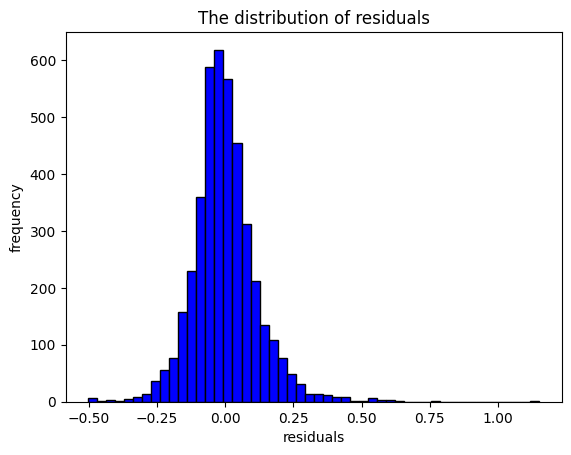

In [ ]:
plt.hist(model.resid, color = 'blue', edgecolor = 'black',
         bins = 50)
plt.xlabel('residuals')
plt.ylabel('frequency')
plt.title("The distribution of residuals")
plt.show()

In [ ]:
print("The mean is:", model.resid.mean())
print("The variance is:", model.resid.var())
print("The skewness is:", model.resid.skew())
print("The kurtosis is:", model.resid.kurtosis())

The mean is: -3.822862638594513e-18
The variance is: 0.014286558438316022
The skewness is: 0.9036439861928063
The kurtosis is: 5.2068430605378415
